In [20]:
import pandas as pd
import numpy as np
import json

In [21]:
from pathlib import Path
from glob import glob

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch import optim

In [23]:
from data_loader import DatasetLoader
from custom_data import PrivacyDataset

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
annotation_path='data/val/val_annotations'
img_path='data/val/val_images'

In [26]:
# Loading data with labels
loader = DatasetLoader()
loaded_data = loader.load_data(annotation_path)

In [27]:
# check for appropriate number of data points
assert(len(loaded_data.index)==4167)

In [28]:
# Visualise data with each label as column an binary encoding
loaded_data.head()

,id,image_path,openimages_id,source_url,a0_safe,a17_color,a6_hair_color,a16_race,a1_age_approx,a24_birth_date,...,a35_mail,a32_drivers_license,a58_hobbies,a79_address_home_partial,a62_opinion_political,a85_username,a97_online_conversation,a13_full_nudity,a7_fingerprint,encoded_label
0,2017_10735550,images/val2017/2017_10735550.jpg,4bb51c80f97a81d6,https://farm7.staticflickr.com/4028/4330838526...,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2017_48376799,images/val2017/2017_48376799.jpg,3db51df4047d9df2,https://farm3.staticflickr.com/8706/1706166171...,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2017_56926780,images/val2017/2017_56926780.jpg,36dcde3b23e915f5,https://farm6.staticflickr.com/4129/4831479058...,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,2017_67658695,images/val2017/2017_67658695.jpg,54d9d29348782d63,https://farm4.staticflickr.com/3951/1535612932...,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,2017_77918314,images/val2017/2017_77918314.jpg,5e055bef92fb869c,https://c5.staticflickr.com/4/3402/3561446980_...,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


#### Debugging

In [29]:
len(loader.file_paths)

4167

In [30]:
loader.file_paths[:10]

['data/val/val_annotations/2017_10735550.json',
 'data/val/val_annotations/2017_48376799.json',
 'data/val/val_annotations/2017_56926780.json',
 'data/val/val_annotations/2017_67658695.json',
 'data/val/val_annotations/2017_77918314.json',
 'data/val/val_annotations/2017_30572559.json',
 'data/val/val_annotations/2017_26691109.json',
 'data/val/val_annotations/2017_80143710.json',
 'data/val/val_annotations/2017_28238181.json',
 'data/val/val_annotations/2017_48868017.json']

In [31]:
'2017_81905864.jpg'

'2017_81905864.jpg'

In [32]:
loaded_data['id'].where(loaded_data['id']=='2017_81905864').dropna()

1667    2017_81905864
Name: id, dtype: object

In [33]:
loaded_data.iloc[1667]

id                                                             2017_81905864
image_path                                  images/val2017/2017_81905864.png
openimages_id                                                           None
source_url                                                              None
a0_safe                                                                    0
                                                 ...                        
a85_username                                                               0
a97_online_conversation                                                    1
a13_full_nudity                                                            0
a7_fingerprint                                                             0
encoded_label              [0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...
Name: 1667, Length: 73, dtype: object

#### End of debugging

In [34]:
train_size=round(len(loaded_data) * 0.8)
val_size=round(len(loaded_data) * 0.2)
train_size + val_size

4167

In [64]:
# Define relevant transformations inc. converting images to tensors
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                                ])

In [65]:
dataset=PrivacyDataset(path=img_path,loaded_data=loaded_data,transform=transform)

In [66]:
train_set, val_set = torch.utils.data.random_split(dataset,[train_size,val_size])

In [67]:
train_loader=DataLoader(dataset=train_set,batch_size=32,shuffle=True)
val_loader=DataLoader(dataset=val_set,batch_size=32,shuffle=True)

#### **Testing output of custom dataset**

In [68]:
img, label = next(iter(train_loader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


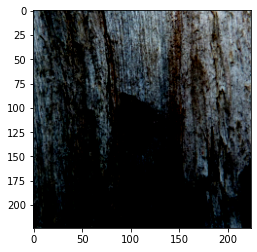

In [69]:
import matplotlib.pyplot as plt
plt.imshow(img[0].permute(1, 2, 0)) # requires channel dimension to be indexed last

In [70]:
label.shape

torch.Size([32, 68])

In [71]:
# TODO: function to convert tensor to class activations
attr=loader.get_attr()
attr

Index(['a0_safe', 'a17_color', 'a6_hair_color', 'a16_race', 'a1_age_approx',
       'a24_birth_date', 'a29_ausweis', 'a2_weight_approx', 'a3_height_approx',
       'a4_gender', 'a5_eye_color', 'a78_address_home_complete',
       'a82_date_time', 'a9_face_complete', 'a18_ethnic_clothing',
       'a55_religion', 'a65_rel_social', 'a10_face_partial',
       'a61_opinion_general', 'a69_rel_views', 'a12_semi_nudity',
       'a64_rel_personal', 'a48_occassion_work', 'a66_rel_professional',
       'a60_occassion_personal', 'a46_occupation', 'a73_landmark',
       'a19_name_full', 'a25_nationality', 'a74_address_current_complete',
       'a8_signature', 'a41_injury', 'a103_license_plate_complete',
       'a26_handwriting', 'a75_address_current_partial', 'a49_phone',
       'a37_receipt', 'a70_education_history', 'a57_culture',
       'a68_rel_spectators', 'a23_birth_city', 'a99_legal_involvement',
       'a59_sports', 'a67_rel_competitors', 'a39_disability_physical',
       'a43_medicine', 'a1

#### **Sample training loop**

In [72]:
# Transfer learning, fine-tuning densenet121 
model = models.densenet121(pretrained=True)

In [73]:
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(nn.Linear(1024, 500),
                           nn.ReLU(),
                           nn.Linear(500, 68),
                           nn.LogSoftmax(dim=1)
                          )
    
model.classifier = classifier

In [74]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr=1e-1)

In [83]:
# Training loop
inputs, label = next(iter(train_loader))

optimizer.zero_grad()
logps = model.forward(inputs)
loss = criterion(logps, labels)
loss.backward()
optimizer.step()

running_loss += loss.item()
print('Running loss: ', running_loss)

# Test loop
inputs, label = next(iter(val_loader))

logps = model.forward(inputs)
batch_loss = criterion(logps, labels)
test_loss += batch_loss.item()

print(logps.shape)
print(logps[0])

# Calculate accuracy
ps = torch.exp(logps)
top_p, top_class = ps.topk(1, dim=1)
equals = top_class == labels.view(*top_class.shape)
accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

Running loss:  1.8124126493930817
torch.Size([32, 68])
tensor([-4.2895, -3.7920, -3.7247, -3.8458, -3.8346, -4.2148, -4.4482, -3.9121,
        -4.1761, -3.8169, -4.2113, -4.1158, -4.1824, -4.1948, -4.6614, -3.9681,
        -4.2453, -3.6889, -4.2214, -4.5875, -4.1196, -4.2109, -4.2566, -4.4217,
        -4.3000, -4.1893, -4.0448, -4.1982, -4.5092, -4.4118, -4.8507, -4.3393,
        -4.4804, -4.5694, -4.2441, -4.3231, -4.1071, -4.2493, -4.4142, -4.3209,
        -4.2451, -4.4872, -4.3864, -4.5375, -4.7042, -4.1395, -4.0230, -4.5402,
        -4.3440, -4.3278, -4.2558, -4.1976, -4.3516, -4.0636, -4.2667, -4.4063,
        -4.3198, -4.4045, -4.3228, -4.6977, -3.9067, -3.8025, -4.3718, -3.9424,
        -4.0765, -4.3116, -4.4481, -4.3896], grad_fn=<SelectBackward>)


RuntimeError: shape '[32, 1]' is invalid for input of size 2176

In [76]:
epochs = 1
steps = 0
running_loss = 0
print_every = 5
for epoch in range(epochs):
    for inputs, labels in train_loader:
        steps += 1

        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        print('MY RUNNING LOSS: ', running_loss)
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, torch.max(labels, 1)[1])
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(val_loader):.3f}.. "
                  f"Test accuracy: {accuracy/len(val_loader):.3f}")
        running_loss = 0
        model.train()

MY RUNNING LOSS:  0.380395770072937
MY RUNNING LOSS:  0.3077383041381836


RuntimeError: stack expects each tensor to be equal size, but got [3, 224, 224] at entry 0 and [1, 224, 224] at entry 27